# HOUSE PREDICTION LINEAR REGRESSION WITH MULTIPLE FEATURES

## Loading the Data set form Kaggle

code to download the dataset

In [1]:
# Import os to create a directory if it doesn’t exist
import os

# Ensure the directory exists for the dataset
dataset_dir = "housing_prices_dataset"
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Download the dataset from Kaggle using the dataset ID (yasserh/housing-prices-dataset)
!kaggle datasets download -d yasserh/housing-prices-dataset -p {dataset_dir} --unzip

print(f"Dataset downloaded to: {dataset_dir}")


Dataset URL: https://www.kaggle.com/datasets/yasserh/housing-prices-dataset
License(s): CC0-1.0

Dataset downloaded to: housing_prices_dataset



  0%|          | 0.00/4.63k [00:00<?, ?B/s]
100%|██████████| 4.63k/4.63k [00:00<00:00, 5.69MB/s]


## Step 1: Importing the Libraries and Loading the Dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Loading the data into a dataframe
file_path = os.path.join(dataset_dir, 'Housing.csv')
df = pd.read_csv(file_path)

df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## Step 2: Data Exploration and Preprocessing, and Data Cleaning and Feature selection

- `.info()` to check all the data types of each column and see if there are any missing values.
- `.isnull().sum()` to count the missing values per column
- `.describe()` to give all summary of statistics of numerical columns, for finding out any outliers and understand the distributions
- `dropna` to remove rows with any missing values

In [3]:
df.info()
df.isnull().sum()
df.describe()
df.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


### Visual Exploration of Data Distributions

Histograms for all numerical feature

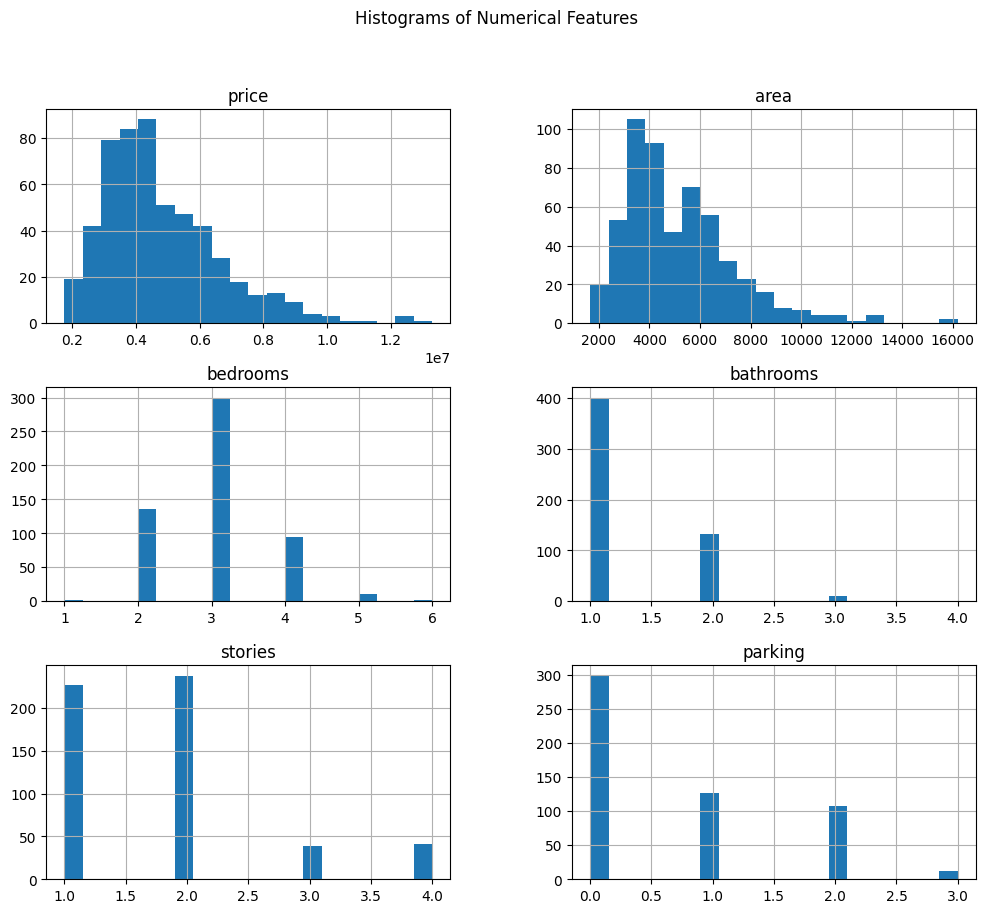

In [4]:
df.hist(bins = 20, figsize=(12,10))
plt.suptitle("Histograms of Numerical Features")
plt.show()

Find categorical data

In [5]:
for column in df.columns:
  if df[column].dtype == 'object':
    print(f"{column}: {df[column].unique()}")

mainroad: ['yes' 'no']
guestroom: ['no' 'yes']
basement: ['no' 'yes']
hotwaterheating: ['no' 'yes']
airconditioning: ['yes' 'no']
prefarea: ['yes' 'no']
furnishingstatus: ['furnished' 'semi-furnished' 'unfurnished']


Convert Non-numeric Data to nomerical data, where 'yes' is 1 and 'no' 0

In [6]:
#columns with yes/no
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Map 'yes' to 1 and 'no' to 0
df[binary_columns] = df[binary_columns].apply(lambda col: col.map({'yes': 1, 'no': 0}))

print(df[binary_columns].head())

   mainroad  guestroom  basement  hotwaterheating  airconditioning  prefarea
0         1          0         0                0                1         1
1         1          0         0                0                1         0
2         1          0         1                0                0         1
3         1          0         1                0                1         1
4         1          1         1                0                1         0


for the furnishingstatus column will be transformed to multiple binary columns, for example it will turn into funishing status_semi-furnished and fusnishingstatus_unfurnished. if both columns are 0 then the furnishing status is furnished

In [7]:
""" # Use one-hot encoding for 'furnishingstatus'
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)

# Convert boolean columns to integers
df['furnishingstatus_semi-furnished'] = df['furnishingstatus_semi-furnished'].astype(int)
df['furnishingstatus_unfurnished'] = df['furnishingstatus_unfurnished'].astype(int)

# Verify the transformation
print(df.head()) """

" # Use one-hot encoding for 'furnishingstatus'\ndf = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)\n\n# Convert boolean columns to integers\ndf['furnishingstatus_semi-furnished'] = df['furnishingstatus_semi-furnished'].astype(int)\ndf['furnishingstatus_unfurnished'] = df['furnishingstatus_unfurnished'].astype(int)\n\n# Verify the transformation\nprint(df.head()) "

For the furnishing since it becomes harder to check out how furnishingstatus impacts the price in the heatmap and also be harder to use as a feature, I will instead use a "naming" system of some kind but numerically, as shown below with an `ordinal scale`


In [8]:
# Map furnishing status to an ordinal scale
furnishing_mapping = {'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2}
df['furnishingstatus_ordinal'] = df['furnishingstatus'].map(furnishing_mapping)

# Verify the new column
print(df[['furnishingstatus', 'furnishingstatus_ordinal']].head())


  furnishingstatus  furnishingstatus_ordinal
0        furnished                         2
1        furnished                         2
2   semi-furnished                         1
3        furnished                         2
4        furnished                         2


Use a Heat map to visualize the data and see how relevant it is to the price, to select features.

In [9]:
df = df.drop(columns=['furnishingstatus'])
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_ordinal
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2


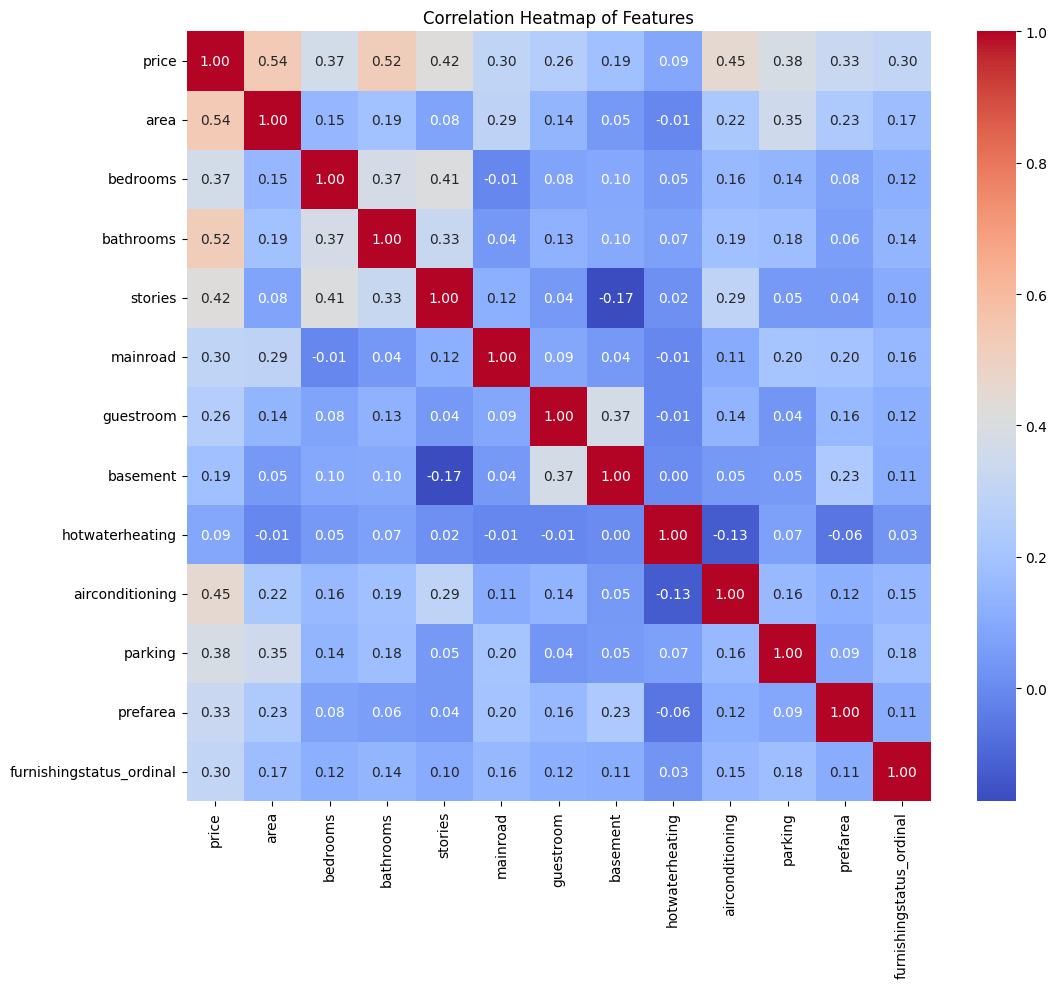

In [10]:
# Correlation heatmap to visualize correlations between numerical features
df

plt.figure(figsize=(12, 10))

corr_matrix = df.corr()


sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()


Based of the Heatmap, I would select the following features for training my model:
1. area
2. bathrooms
3. stories
4. airconditioning
5. parking

as they scored higher on the heat map, however I would test out how relevant the following features are, as they seem quite obvious to affect the house pricing based of human intuition:
1. bedrooms
2. furnishingstatus

In [11]:
X = df[['area', 'bathrooms', 'stories', 'airconditioning', 'parking', 'bedrooms']]

y= df['price']

X.head(), y.head()

(   area  bathrooms  stories  airconditioning  parking  bedrooms
 0  7420          2        3                1        2         4
 1  8960          4        4                1        3         4
 2  9960          2        2                0        2         3
 3  7500          2        2                1        3         4
 4  7420          1        2                1        2         4,
 0    13300000
 1    12250000
 2    12250000
 3    12215000
 4    11410000
 Name: price, dtype: int64)

## Step 3: Scaling the Data and Splitting the Dataset

### Scaling the data
Scaling is mostly done when model's features have diffrent ranges, `area` has values in thousands and `bedrooms` might be a single-digit number.

#### Reason to scale:
- Distance based models, such as **Linear regression**, are affected by the magnitude of the features.
- Normalization and standardization, to ensure that each feature contributes equally, to prevent large features form dominating the model's calculations.

#### Types of Scaling

##### Standardization (Z-score scaling)
This transforms the data to have a mean of 0 and a standard deviation of 1.
`Formula:`
$$
z = \frac{x - \text{mean}}{\text{std deviation}}
$$
Use when features have a roughly Gaussian (normal) distribution.

##### Normalization (Min-Max scaling)
This scales the data to a fixed range, usually [0, 1].
`Formula:`
$$
z = \frac{x - \min(x)}{\max(x) - \min(x)}
$$
Useful for non-Gaussian distributions or when you need values in a specific range (e.g., neural networks often perform better with values between 0 and 1).
